In [23]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import math
import matplotlib.pyplot as plt

In [24]:
# hyperparameters
batch_size = 32 # how many independent sequences will we process in parallel?
block_size = 16 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
num_groups = 2  
window_size = 5

In [25]:
torch.manual_seed(1337)

In [26]:
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [27]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

In [28]:
# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]


In [29]:
# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [30]:
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [31]:
class RotaryPositionalEmbedding(nn.Module):
    def __init__(self, dim, max_seq_len=512):
        super().__init__()
        # Create constant 'pe' matrix with values dependent on 
        # pos and i
        pe = torch.zeros(max_seq_len, dim)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, dim, 2).float() * (-math.log(10000.0) / dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: [batch_size, seq_len, embedding_dim]
        # Apply RoPE to x
        x = x + self.pe[:, :x.size(1)]
        return x


In [32]:
class GroupQueryAttention(nn.Module):
    def __init__(self, head_size, num_groups):
        super().__init__()
        self.head_size = head_size
        self.num_groups = num_groups

    def forward(self, query, key, value):
        # Ensure the head_size is divisible by num_groups
        if self.head_size % self.num_groups != 0:
            raise ValueError("head_size must be divisible by num_groups")

        # Reshape query, key, and value for group-wise attention
        # The shape will be [batch_size, seq_length, num_groups, head_size_per_group]
        query_groups = query.view(query.size(0), query.size(1), self.num_groups, -1)
        key_groups = key.view(key.size(0), key.size(1), self.num_groups, -1)
        value_groups = value.view(value.size(0), value.size(1), self.num_groups, -1)

        # Compute attention scores
        # 'bthg,bshg->btsg' means:
        #   - b = batch size
        #   - t = target sequence length
        #   - s = source sequence length
        #   - h = head size
        #   - g = number of groups
        attention_scores = torch.einsum('bthg,bshg->btsg', query_groups, key_groups)
        attention_scores = F.softmax(attention_scores, dim=-1)

        # Compute weighted sum of values
        out = torch.einsum('btsg,bshg->bthg', attention_scores, value_groups)

        # Reshape to concatenate the groups
        out = out.reshape(query.size(0), query.size(1), -1)
        return out


In [33]:
# Sliding Window Attention
def sliding_window_mask(seq_len, window_size, device):
    center = torch.arange(seq_len, device=device).unsqueeze(0)
    mask = torch.abs(center - center.T) <= window_size
    return mask

In [34]:
class ModifiedHead(nn.Module):
    """ One head of self-attention with Group Query Attention and Sliding Window Attention """

    def __init__(self, n_embd, head_size, num_groups, window_size):
        super().__init__()
        self.num_groups = num_groups
        self.window_size = window_size
        self.head_size = head_size

        # Linear transformations for key, query, and value
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)

        # Group Query Attention
        self.group_query_attention = GroupQueryAttention(head_size, num_groups)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, _ = x.shape

        # Compute key, query, and value
        k = self.key(x)   # (B, T, head_size)
        q = self.query(x) # (B, T, head_size)
        v = self.value(x) # (B, T, head_size)
        q = q.view(B, T, self.num_groups, -1)

        # Create the sliding window mask for each group
        window_mask = sliding_window_mask(T, self.window_size, x.device)
        window_mask = window_mask.unsqueeze(1).repeat(1, self.num_groups, 1, 1)
        # Apply the mask to the reshaped query tensor
        q = q.view(B, T, self.num_groups, self.head_size // self.num_groups)
        #q = q.masked_fill(~window_mask.unsqueeze(2), float('-inf'))
        q = q.view(B, T, -1)  # Reshape back
        # Compute attention using the masked query
        out = self.group_query_attention(q, k, v)

        # Concatenate the output from each group and apply dropout
        out = out.view(B, T, self.head_size)
        out = self.dropout(out)
        return out


In [35]:
class MultiHeadAttention(nn.Module):
    """ Multiple heads of self-attention in parallel with Group Query Attention and Sliding Window Attention """

    def __init__(self, num_heads, head_size, num_groups, window_size):
        super().__init__()
        self.num_heads = num_heads
        self.head_size = head_size
        self.num_groups = num_groups
        self.window_size = window_size

        # Create head modules
        self.heads = nn.ModuleList([ModifiedHead(n_embd, head_size, num_groups, window_size) for _ in range(num_heads)])
        
        # Projection for the concatenated output of all heads
        self.proj = nn.Linear(num_heads * head_size, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Concatenate the output of all heads
        out = torch.cat([h(x) for h in self.heads], dim=-1)

        # Project back to the original embedding size and apply dropout
        out = self.dropout(self.proj(out))
        return out


In [36]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)
    

In [37]:
class Block(nn.Module):
    """ Transformer block with Group Query Attention and Sliding Window Attention """

    def __init__(self, n_embd, n_head, head_size, num_groups, window_size):
        super().__init__()
        self.n_head = n_head
        self.head_size = head_size
        self.num_groups = num_groups
        self.window_size = window_size

        # Initialize MultiHeadAttention with additional parameters
        self.sa = MultiHeadAttention(n_head, head_size, num_groups, window_size)

        # Point-wise feed-forward network
        self.ffwd = FeedFoward(n_embd)
        
        # Layer normalization layers
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        # Apply self-attention
        x = x + self.sa(self.ln1(x))

        # Apply feed-forward network
        x = x + self.ffwd(self.ln2(x))
        return x


In [38]:
import math

class RotaryPositionalEmbedding(nn.Module):
    def __init__(self, dim, max_seq_len=512):
        super().__init__()
        # Create constant 'pe' matrix with values dependent on 
        # pos and i
        pe = torch.zeros(max_seq_len, dim)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, dim, 2).float() * (-math.log(10000.0) / dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: [batch_size, seq_len, embedding_dim]
        # Apply RoPE to x
        x = x + self.pe[:, :x.size(1)]
        return x


In [43]:
class MyLM_model(nn.Module):    
    def __init__(self):
        super().__init__()
        head_size = n_embd // n_head 

        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.rotary_pos_emb = RotaryPositionalEmbedding(n_embd, block_size)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head, head_size, num_groups, window_size) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        tok_emb = self.token_embedding_table(idx) # (Batch, Time, Channel)
        pos_emb = self.rotary_pos_emb(tok_emb)
        x = tok_emb + pos_emb # (B, T, C)
        x = self.blocks(x) # (B, T, C)
        x = self.ln_f(x) # (B, T, C)
        logits = self.lm_head(x) # (B, T, Vocab_size)
        
        loss = None
        if targets is not None:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] # (B, C)
            probs = F.softmax(logits, dim=-1) # (B, C)
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [44]:
model = MyLM_model()
m = model.to(device)


In [45]:

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)


step 0: train loss 3.9424, val loss 3.9492
step 100: train loss 2.4156, val loss 2.5504
step 200: train loss 1.9097, val loss 2.1963
step 300: train loss 1.5717, val loss 2.0734
step 400: train loss 1.2980, val loss 2.0132
step 500: train loss 1.0776, val loss 2.0224
step 600: train loss 0.9080, val loss 2.1022
step 700: train loss 0.7519, val loss 2.2191
step 800: train loss 0.6534, val loss 2.3362
step 900: train loss 0.5496, val loss 2.4616
step 1000: train loss 0.4571, val loss 2.5044
step 1100: train loss 0.3906, val loss 2.7033
step 1200: train loss 0.3275, val loss 2.8324
step 1300: train loss 0.2820, val loss 2.8913
step 1400: train loss 0.2386, val loss 3.0064
step 1500: train loss 0.2172, val loss 3.0814
step 1600: train loss 0.1791, val loss 3.2204
step 1700: train loss 0.1870, val loss 3.2873
step 1800: train loss 0.1329, val loss 3.3753
step 1900: train loss 0.1133, val loss 3.5577
step 2000: train loss 0.1235, val loss 3.5536
step 2100: train loss 0.1049, val loss 3.6398


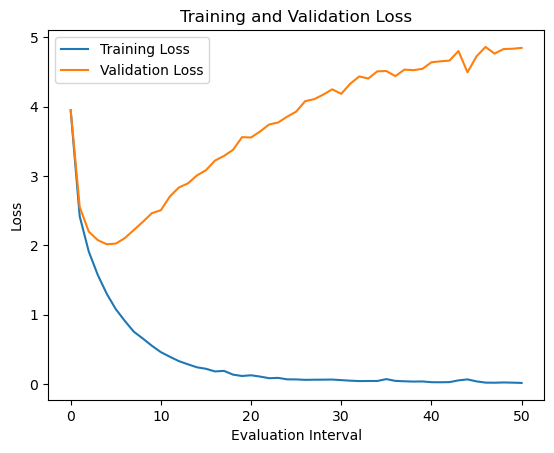

In [46]:
train_losses = []
val_losses = []

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        train_losses.append(losses['train'].item())
        val_losses.append(losses['val'].item())
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Evaluation Interval')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [47]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=1000)[0].tolist()))




ThiziziziziDnim GIghe mizay mumumummmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm